# Decision Tree 

### Imports


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from pprint import pprint

%matplotlib inline
sns.set_style("darkgrid")


### Load the dataset


In [2]:
df = pd.read_csv('ricsBigData.csv')#load Dataset

if(df.columns[0]=='Unnamed: 0'): 
    
    df=df.iloc[:,1:]#only use the feature and Label Colloums 

In [3]:
df.head()

,Rel_BreitGross,RelSpitze_oben,RelSpitze_unten,Anzahl_Linie,Anzahl_Ecken,Anzahl_Kreis,Label
0,0.291153,0.009050,0.651584,9,2,0,0
1,0.338341,0.556122,0.750000,10,5,0,0
2,0.726178,0.985294,0.989496,6,8,0,0
3,0.316422,0.738397,0.616034,27,15,0,0
4,0.260098,0.175510,0.640816,15,8,0,0


### Split the Data


In [4]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [5]:
train_df,test_df=train_test_split(df,0.6)

### Check if the Data is pure 


In [6]:
def check_purity(data): #Input is a numpy 2D arry 
    
    label_column = data[:, -1]  # store the values of the label column
    unique_classes = np.unique(label_column)#store all unique values in an arary 

    if len(unique_classes) == 1: #check if ther is only on class. Therfore it is unique
        return True
    else:
        return False

### clasify the Data

In [7]:
def classify_data(data):#Input is a numpy 2D arry 
    
    label_column = data[:, -1]   # store the values of the label column
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)#returns a arry with the classes and one with the count of classes

    index = counts_unique_classes.argmax()#returns the class witch appears the most 
    classification = unique_classes[index]
    
    return classification

### Potential Splits


In [8]:
def get_potential_splits(data): #Input is a numpy 2D arry 
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1): # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)#store the unique values sorted 
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

### Plot the potential Split in an Scatterplot 

c:\Users\jonas\Documents\08_Master\Python_Projekte\Verfahren_der_KI\KIProjekt\env\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


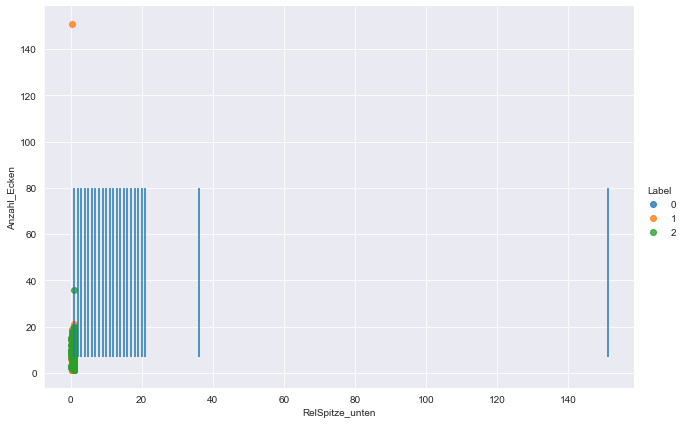

In [9]:
### TODO add to Data_vorbereitung 
potentialsplits=get_potential_splits(train_df.values) #get the potential Splits 
sns.lmplot(data=train_df,x="RelSpitze_unten",y="Anzahl_Ecken",fit_reg=False,hue="Label",size=6,aspect=1.5) #Plot a scatterplot for two chosen columns 
plt.vlines(x=potentialsplits[4],ymin=7,ymax=80)#draw the potential Splits for the chosen row 

### Split the data 


In [10]:
def split_data(data, split_column, split_value):#check if the given data is below or above a given split_value 
    
    split_column_values = data[:, split_column] #store all values of a chosen column 

    data_below = data[split_column_values <= split_value] #only choose the values that are above the split_value 
    data_above = data[split_column_values >  split_value] #only choose the values that are below the split_value 
    
    return data_below, data_above

### lowest Overall Entropy 

In [11]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True) # count the unique values for each class 

    probabilities = counts / counts.sum() #calculate the probability for each class 
    entropy = sum(probabilities * -np.log2(probabilities)) #calculate the entropy 
     
    return entropy

In [12]:
def calculate_overall_entropy(data_below, data_above): 
    
    n = len(data_below) + len(data_above) #count the total number of values 
    p_data_below = len(data_below) / n  #count the total number of the data_below 
    p_data_above = len(data_above) / n  #count the total number of the data_above 

    overall_entropy =  (p_data_below * calculate_entropy(data_below) #calculate the total entropy 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

### find the best split based on the calculated entropy 

In [13]:
#calculate all the entropies for the potential splits and store the lowest one and the responding column and the split value 
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [14]:
potentialsplits=get_potential_splits(train_df.values)
determine_best_split(train_df.values,potentialsplits)

(4, 5.0)

In [15]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [16]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [17]:
#tree=decision_tree_algorithm(train_df,max_depth=10)
tree=decision_tree_algorithm(train_df,max_depth=3)
pprint(tree)

{'Anzahl_Ecken <= 5.0': [{'Anzahl_Linie <= 7.0': [{'RelSpitze_unten <= 0.2953020134228188': [2.0,
                                                                                             1.0]},
                                                  {'RelSpitze_unten <= 0.4838709677419355': [1.0,
                                                                                             0.0]}]},
                         {'RelSpitze_oben <= 0.9158316633266532': [{'RelSpitze_oben <= 0.4128686327077748': [0.0,
                                                                                                             2.0]},
                                                                   {'Anzahl_Linie <= 0.0': [1.0,
                                                                                            2.0]}]}]}


### Classify a given example 

In [18]:
example=test_df.iloc[0]
example

Rel_BreitGross     0.352716
RelSpitze_oben     1.000000
RelSpitze_unten    0.411085
Anzahl_Linie       2.000000
Anzahl_Ecken       1.000000
Anzahl_Kreis       1.000000
Label              1.000000
Name: 374, dtype: float64

In [19]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":  # feature is continuous
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [20]:
classify_example(example,tree)

1.0

### Calculate the Accuracy

In [21]:
def calculate_accuracy(df, tree):
    
    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["Label"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy



In [22]:
accuracy = calculate_accuracy(test_df, tree)
accuracy

0.546583850931677